In [10]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [12]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [13]:
#Specifying the paramenters of our model
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [14]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:39577296896.0
Coefficients:  tensor([[ 3.6194e+01,  1.0650e-02, -2.8493e-02,  5.6983e-01,  4.2313e+00]])
-------------------
2th epoch
Loss ols:29200748544.0
Coefficients:  tensor([[ 6.7890e+01,  3.2884e-02, -9.2178e-03,  8.7744e-01,  8.1656e+00]])
-------------------
3th epoch
Loss ols:24213850112.0
Coefficients:  tensor([[9.7356e+01, 5.4582e-02, 1.0943e-02, 1.1763e+00, 1.1467e+01]])
-------------------
4th epoch
Loss ols:29544923136.0
Coefficients:  tensor([[1.2843e+02, 8.0043e-02, 3.3170e-02, 1.5655e+00, 1.5175e+01]])
-------------------
5th epoch
Loss ols:36341452800.0
Coefficients:  tensor([[1.6281e+02, 1.1825e-01, 6.6929e-02, 2.6326e+00, 2.0897e+01]])


In [15]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [16]:
#Loading in complex MNIST train and test datasets while transforming them to 64
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

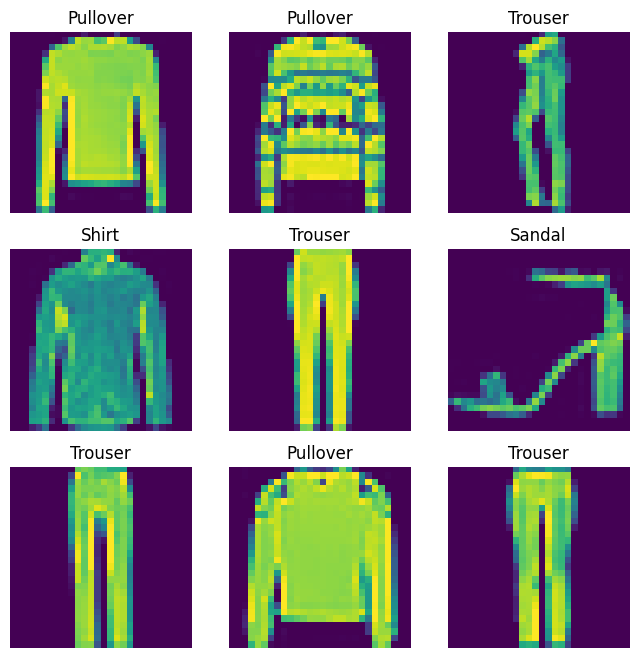

In [17]:
#Visualizing 9 random examples

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()



In [18]:
#Splitting our data into batch sizes
mnist_batch_size = 256

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [19]:
#Creating the model and initializing the weights
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

In [47]:
#Creating a class for displaying the results
class evaluation:
    """For evaluating the accuracy of image recognition neural networks"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.net = net
        self.img = img
        self.label = label
    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(img).double()
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities
    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred
    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)
    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != label)/len(self.label)
    def add(self,img,label):
        """Appends an error rate (and loss if not None) to the history of error rates (used for in-sample error rate during training)"""
        self.img = img
        self.label = label
        self.hist.append(self.error())


    def __getitem__(self, idx):
        return self.hist[idx]
    def plot(self):
        """Plots the in-sample error and loss (if such has been added) from history"""

        plt.plot(self.hist)
        plt.ylabel('In-sample error')
        plt.xlabel('Epoch')
        plt.show()


In [48]:
#Creating an automatic trainer to be used with sequential linear classes
class Gradient_Trainer:
    """Automatic trainer for linear classifiers embedded through a sequential class"""
    def __init__(self,net,train_iter,loss,trainer,test_iter=None):
        self.net = net
        self.train_iter = train_iter
        self.loss = loss
        self.trainer = trainer
        self.test_iter = test_iter
    def reset(self, std = 0.1):
        """Used for resetting the weights of the neural network for retrainment"""
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=std)

        self.net.apply(init_weights)

    def Train(self,num_epochs,ploss = False,perror = False,graph = False):
        """Used for training the neural network
                :param ploss: - print loss for each epoch
                :param perror: - print error for each epoch
                :param graph: - graph in-sample error at the end of training"""
        self.net.train()
        eval = evaluation(net=self.net)
        for epoch in range(num_epochs):
            if ploss is True or perror is True:
                print('-------------------')
                print(f'{epoch+1}th epoch')
                print('===================')
            self.net.zero_grad()
            img, label = next(iter(self.train_iter))
            output = self.net(img).double()
            l = self.loss(output,label)
            l.mean().backward()
            self.trainer.step()
            eval.add(img,label)
            if ploss is True:
                print("Loss:",l.sum().item())
            if perror is True:
                print("In-sample error:",eval.error())
        if graph is True:
            eval.plot()
        self.eval = eval

    def Test(self,test_iter):
        if self.test_iter is None:
            self.test_iter = test_iter
        next, label = next(iter(self.test_iter))
        result = evaluation(net=self.net,img=img,label=label)
        print("Out-of-sample error:",result.error())
        self.result = result




In [30]:
num_epochs = 50
ev = evaluation(net = logit_net)
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    logit_net.train()
    logit_net.zero_grad()
    img, label = next(iter(mnist_train_iter))
    output = logit_net(img)

    l = logit_loss(output,label)


    l.mean().backward(retain_graph=True)

    logit_trainer.step()
    ev.add(img,label)
    print("In-sample error rate:",ev.error())


-------------------
1th epoch
In-sample error rate: tensor(0.3281)
-------------------
2th epoch
In-sample error rate: tensor(0.3906)
-------------------
3th epoch
In-sample error rate: tensor(0.3750)
-------------------
4th epoch
In-sample error rate: tensor(0.3867)
-------------------
5th epoch
In-sample error rate: tensor(0.4023)
-------------------
6th epoch
In-sample error rate: tensor(0.2930)
-------------------
7th epoch
In-sample error rate: tensor(0.3984)
-------------------
8th epoch
In-sample error rate: tensor(0.3438)
-------------------
9th epoch
In-sample error rate: tensor(0.3398)
-------------------
10th epoch
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/bartoszgawin/lib/python3.10/site-packages/torchvision/__init__.py", l

In [ ]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

In [49]:
#Perceptron initiation

MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

MLP.apply(init_weights)

MLP_loss = nn.CrossEntropyLoss(reduction='none')

MLP_trainer = torch.optim.SGD(MLP.parameters(),lr = 0.1)

-------------------
1th epoch
Loss: 589.3154503085575
In-sample error: tensor(0.9062)
-------------------
2th epoch
Loss: 587.6276762279866
In-sample error: tensor(0.9297)
-------------------
3th epoch
Loss: 585.6754369217028
In-sample error: tensor(0.9297)
-------------------
4th epoch
Loss: 584.477491479704
In-sample error: tensor(0.9297)
-------------------
5th epoch
Loss: 583.098388547882
In-sample error: tensor(0.9297)
-------------------
6th epoch
Loss: 580.3947164556185
In-sample error: tensor(0.9297)
-------------------
7th epoch
Loss: 578.130959273232
In-sample error: tensor(0.9297)
-------------------
8th epoch
Loss: 577.6144442892123
In-sample error: tensor(0.8984)
-------------------
9th epoch
Loss: 573.5437936395533
In-sample error: tensor(0.8789)
-------------------
10th epoch
Loss: 569.5603351550354
In-sample error: tensor(0.8984)
-------------------
11th epoch
Loss: 567.8254560709128
In-sample error: tensor(0.8633)
-------------------
12th epoch
Loss: 565.9550595632415


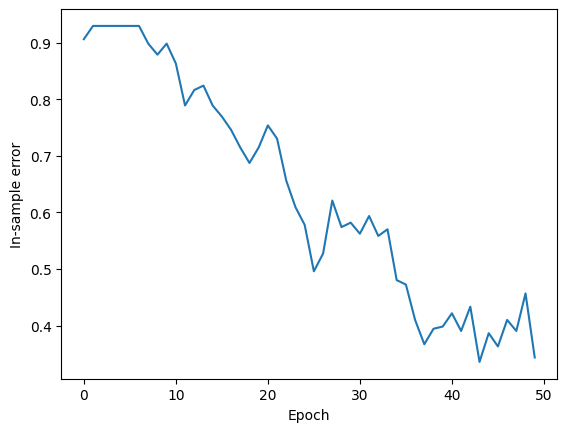

In [50]:
MLP_Training = Gradient_Trainer(MLP,mnist_train_iter,MLP_loss,MLP_trainer,mnist_test_iter)
MLP_Training.Train(50,True,True,True)